In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA2'

In [1]:
!du -sh /home/roman/mne_data


60G	/home/roman/mne_data


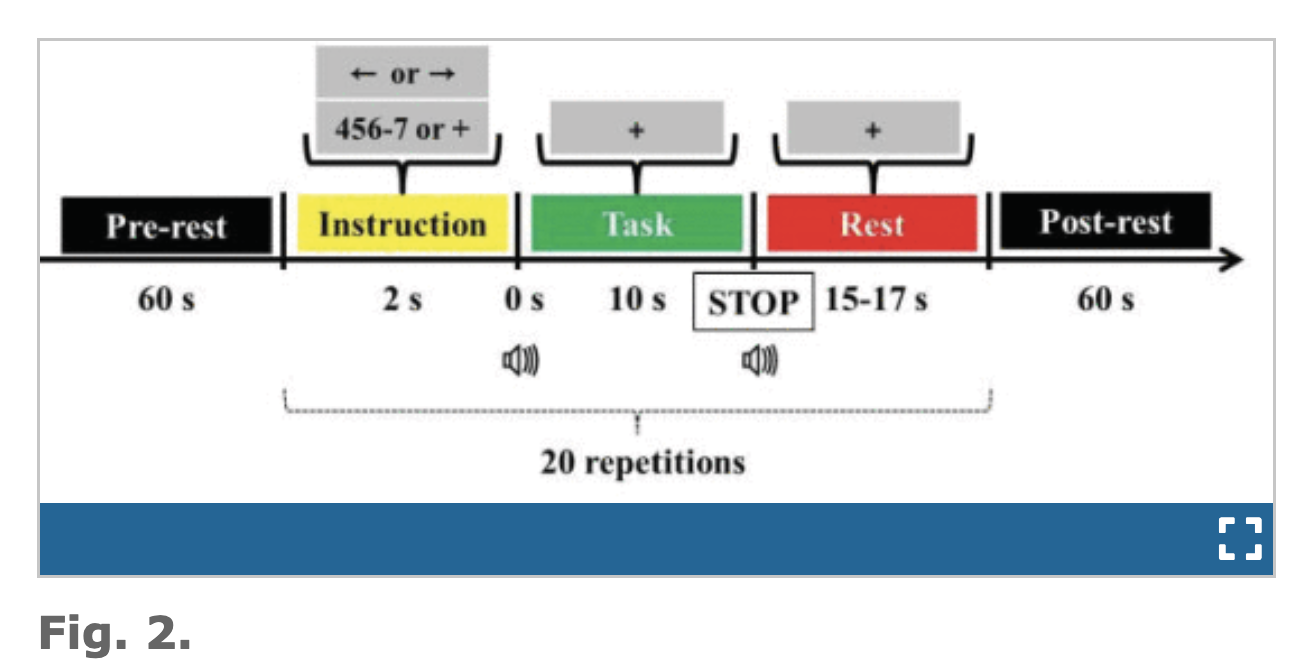

https://ieeexplore.ieee.org/document/7742400

In [2]:
import sys, os, torch
from tqdm import tqdm
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
%%time

ds = Shin2017A(accept=True)

print(f'N_subj: {len(ds.subject_list)}')


# ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
# Convert the average of AFFs into Fz
ChOI = ['AFF1h', 'AFF2h', 'F3', 'F4', 'Cz', 'P3', 'P4', 'Pz']
eventsOI  = ['left_hand', 'right_hand']

subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=0,
                            tmax=None, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)
    print(ch_names)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)



N_subj: 29


  0%|                                                                                                                                  | 0/29 [00:00<?, ?it/s]

['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


  3%|████▏                                                                                                                     | 1/29 [00:02<01:14,  2.67s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


  7%|████████▍                                                                                                                 | 2/29 [00:05<01:11,  2.65s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 10%|████████████▌                                                                                                             | 3/29 [00:07<01:07,  2.60s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 14%|████████████████▊                                                                                                         | 4/29 [00:10<01:04,  2.60s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 17%|█████████████████████                                                                                                     | 5/29 [00:12<01:01,  2.58s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 21%|█████████████████████████▏                                                                                                | 6/29 [00:15<00:59,  2.58s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 24%|█████████████████████████████▍                                                                                            | 7/29 [00:18<00:56,  2.57s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 28%|█████████████████████████████████▋                                                                                        | 8/29 [00:20<00:53,  2.54s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 31%|█████████████████████████████████████▊                                                                                    | 9/29 [00:23<00:50,  2.53s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 34%|█████████████████████████████████████████▋                                                                               | 10/29 [00:25<00:47,  2.53s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 38%|█████████████████████████████████████████████▉                                                                           | 11/29 [00:28<00:45,  2.52s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 41%|██████████████████████████████████████████████████                                                                       | 12/29 [00:30<00:42,  2.52s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 45%|██████████████████████████████████████████████████████▏                                                                  | 13/29 [00:33<00:40,  2.52s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 48%|██████████████████████████████████████████████████████████▍                                                              | 14/29 [00:35<00:37,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 52%|██████████████████████████████████████████████████████████████▌                                                          | 15/29 [00:38<00:35,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 55%|██████████████████████████████████████████████████████████████████▊                                                      | 16/29 [00:40<00:32,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 59%|██████████████████████████████████████████████████████████████████████▉                                                  | 17/29 [00:43<00:30,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 62%|███████████████████████████████████████████████████████████████████████████                                              | 18/29 [00:45<00:27,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 19/29 [00:48<00:25,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 69%|███████████████████████████████████████████████████████████████████████████████████▍                                     | 20/29 [00:50<00:22,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 72%|███████████████████████████████████████████████████████████████████████████████████████▌                                 | 21/29 [00:53<00:20,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                             | 22/29 [00:55<00:17,  2.51s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▉                         | 23/29 [00:58<00:15,  2.52s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 24/29 [01:00<00:12,  2.52s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 25/29 [01:03<00:10,  2.52s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 26/29 [01:05<00:07,  2.53s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 27/29 [01:08<00:05,  2.53s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 28/29 [01:10<00:02,  2.55s/it]

(60, 8, 600), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:13<00:00,  2.54s/it]

(60, 8, 600), ['left_hand' 'right_hand']
CPU times: user 1min 10s, sys: 2.47 s, total: 1min 13s
Wall time: 1min 13s


In [5]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# interpolate Fz (as an average of AFF5h and AFF6h channels)

Fz = samples[:,:2,:].mean(axis=1, keepdims=True)
print(Fz.shape)

samples_woAFF_withFz = np.concatenate([Fz, samples[:,2:,:]], axis=1)
# now the channels are arranged like this: ['Fz, 'F3', 'F4', 'Cz', 'P3', 'P4', 'Pz']]
# but need to be like this ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'], so we fix that:


rearranged_chans = samples_woAFF_withFz[:, np.array([1,2,0,3,4,5,6]), :]

print(rearranged_chans.shape)

(1740, 1, 600)
(1740, 7, 600)


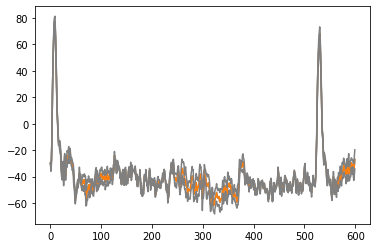

In [6]:
# check it:

plt.plot(samples_woAFF_withFz[0, 0, :].T, label='Fz')
plt.plot(rearranged_chans[0, 2, :].T, label='Fz_rearr')
plt.plot(samples[0,:2,:].T, color='grey')

In [7]:
labelsToIDs = {"right_hand": 0, "left_hand": 1}

def save_to_torch(samples, meta, ds):    
    torch.save({'samples': torch.from_numpy(rearranged_chans).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'],
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

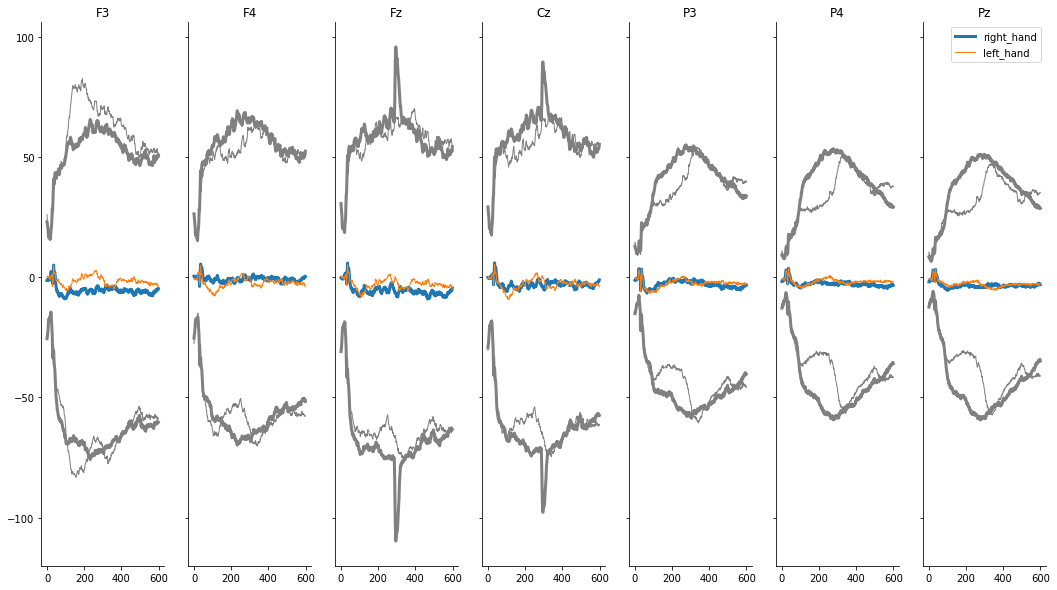

In [8]:
rights = np.where(meta.label.map(labelsToIDs) == 0)[0]
lefts = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1,7, figsize=(18,10), sharey=True)
for i in range(7):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[lefts,i,:].mean(0).squeeze()
    s = samples[lefts,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='left_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()